# Project 2: Vinamra Rai (406306460)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.linalg
import time

## Lecture 4: Binomial-tree and Trinomial-tree models

### 1. Comparing Convergence Rates

In [3]:
# defining the parameters for option pricing
S0 = 180
K = 180
T = 0.5
r = 0.055
sigma = 0.25

steps = [20, 40, 80, 100, 200, 500]

#### 1(a) Binomial Method 1

In [4]:
def calc_american_put_price_1(S0, K, T, r, sigma, n):

  # calculating delta t
  dt = T / n

  # calculating up and down factors and risk-neutral probability
  c = 0.5 * (np.exp(-r * dt) + np.exp((r + sigma**2) * dt))
  d = c - np.sqrt(c**2 - 1)
  u = 1 / d
  p = (np.exp(r * dt) - d) / (u - d)

  # initializing asset prices at maturity
  node_prices = np.zeros(n + 1)
  for i in range(n + 1):
      node_prices[i] = S0 * (u ** (n - i)) * (d ** i)

  # initializing option values at maturity
  option_values = np.maximum(K - node_prices, 0)

  # generating backward induction for option price before maturity
  for i in range(n - 1, -1, -1):
      for j in range(i + 1):
          exercise = K - S0 *  (u ** (i - j)) * (d ** j)
          continuation = np.exp(-r * dt) * (p * option_values[j] + (1 - p) * option_values[j + 1])
          # Option value is the max of exercise and continuation
          option_values[j] = max(exercise, continuation)

  return option_values[0]

prices_1 = [calc_american_put_price_1(S0, K, T, r, sigma, n) for n in steps]

#### 1(b) Binomial Method 2

In [5]:
def calc_american_put_price_2(S0, K, T, r, sigma, n):

  # calculating delta t
  dt = T / n

  # calculating up and down factors and risk-neutral probability
  u = np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt))
  d = np.exp((r - 0.5 * sigma**2) * dt - sigma * np.sqrt(dt))
  p = 0.5

  # initializing asset prices at maturity
  node_prices = np.zeros(n + 1)
  for i in range(n + 1):
      node_prices[i] = S0 * (u ** (n - i)) * (d ** i)

  # initializing option values at maturity
  option_values = np.maximum(K - node_prices, 0)

  # generating backward induction for option price before maturity
  for i in range(n - 1, -1, -1):
      for j in range(i + 1):
          exercise = K - S0 * (u ** (i - j)) * (d ** j)
          continuation = np.exp(-r * dt) * (p * option_values[j] + (1 - p) * option_values[j + 1])
          option_values[j] = max(exercise, continuation)

  return option_values[0]

prices_2 = [calc_american_put_price_2(S0, K, T, r, sigma, n) for n in steps]

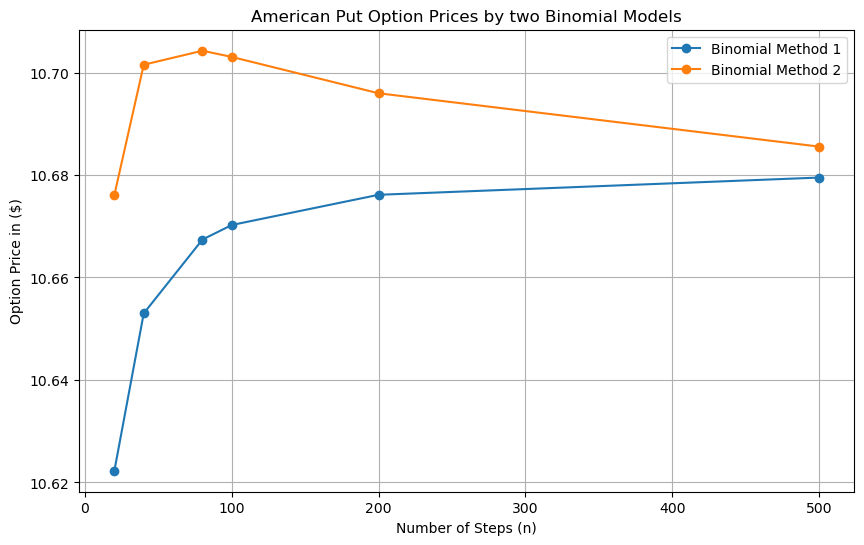

In [6]:
# plotting the American Put Option Prices using both the methods
plt.figure(figsize=(10, 6))
plt.plot(steps, prices_1, marker='o', label='Binomial Method 1')
plt.plot(steps, prices_2, marker='o', label='Binomial Method 2')
plt.xlabel('Number of Steps (n)')
plt.ylabel('Option Price in ($)')
plt.title('American Put Option Prices by two Binomial Models')
plt.grid(True)
plt.legend()
plt.show()

### 2. Plotting American Put Option Greeks

In [7]:
# redefining all the parameters
S0 = 180
K = 180
T = 0.5
r = 0.055
sigma = 0.25
n = 100

In [8]:
# defining the functions to compute the option prices and greeks

def calc_americanput_crr(S0, K, T, r, sigma, n):
    if T == 0:
        # At maturity, the option value is simply its intrinsic value
        return max(K - S0, 0)

    dt = np.abs(T / n)
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    # p = (np.exp(r * dt) - d) / (u - d)
    p = 0.5 * (1 + ((r - 0.5 * sigma ** 2) * np.sqrt(dt)) / sigma)

    # initializing arrays for stock prices and option values
    prices = S0 * np.array([u**(n-i) * d**i for i in range(n+1)])
    option_values = np.maximum(K - prices, 0)

    # generating backward induction for option price before maturity
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            exercise = K - S0 * u**(i-j) * d**j
            continuation = np.exp(-r * dt) * (p * option_values[j] + (1 - p) * option_values[j+1])
            option_values[j] = max(exercise, continuation)

    return option_values[0]

def calc_delta(S0, K, T, r, sigma, n):
    eps = 1  # A small change in S0
    price_up = calc_americanput_crr(S0 + eps, K, T, r, sigma, n)
    price_down = calc_americanput_crr(S0 - eps, K, T, r, sigma, n)
    return (price_up - price_down) / (2 * eps)

def calc_theta(S0, K, T, r, sigma, n):
    eps = 0.0001  # A small change in T
    price_up = calc_americanput_crr(S0, K, T, r, sigma, n)
    price_down = calc_americanput_crr(S0, K, np.abs(T - eps), r, sigma, n)
    return -(price_up - price_down) / eps

def calc_vega(S0, K, T, r, sigma, n):
    eps = sigma * 0.001  # A small change in sigma
    price_up = calc_americanput_crr(S0, K, T, r, sigma + eps, n)
    price_down = calc_americanput_crr(S0, K, T, r, sigma - eps, n)
    return (price_up - price_down) / (2 * eps)

# computing the values

deltas = []
delta_T = []
thetas = []
vegas =[]

S0_values = np.arange(170, 191, 2)
T_values = np.arange(0, 0.181, 0.003)
T_values_2 = np.arange(0.001, 0.181, 0.003)
deltas = [calc_delta(S, K, T, r, sigma, n) for S in S0_values]
delta_T = [calc_delta(S0, K, T, r, sigma, n) for T in T_values]
thetas = [calc_theta(S0, K, T, r, sigma, n) for T in T_values_2]
vegas = [calc_vega(S, K, T, r, sigma, n) for S in S0_values]

#### 2(i) Delta of an American Put Option as a function of underlying

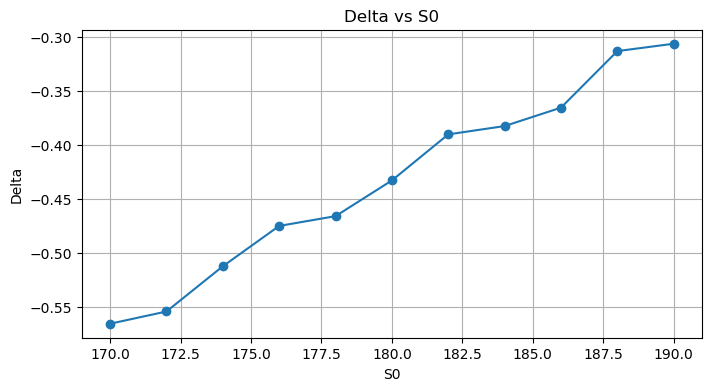

In [9]:
# Plotting Delta
plt.figure(figsize=(8, 4))
plt.plot(S0_values, deltas, label='Delta', marker='o')
plt.title('Delta vs S0')
plt.xlabel('S0')
plt.ylabel('Delta')
plt.grid(True)
plt.show()

#### 2(ii) Delta of an American Put Option as a function of time

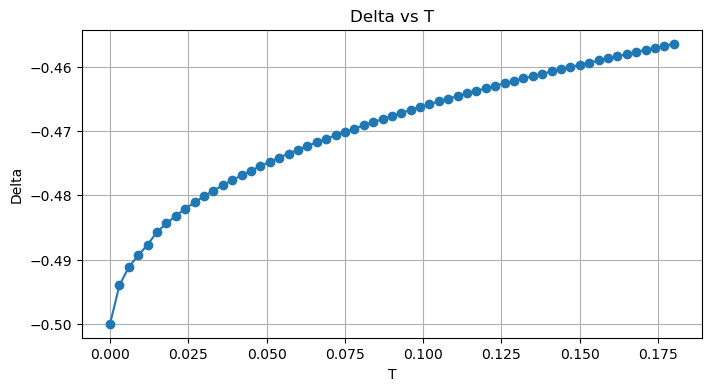

In [10]:
# Plotting Delta
plt.figure(figsize=(8, 4))
plt.plot(T_values, delta_T, label='Delta', marker='o')
plt.title('Delta vs T')
plt.xlabel('T')
plt.ylabel('Delta')
plt.grid(True)
plt.show()

#### 2(iii) Theta of an American Put Option as a function of time

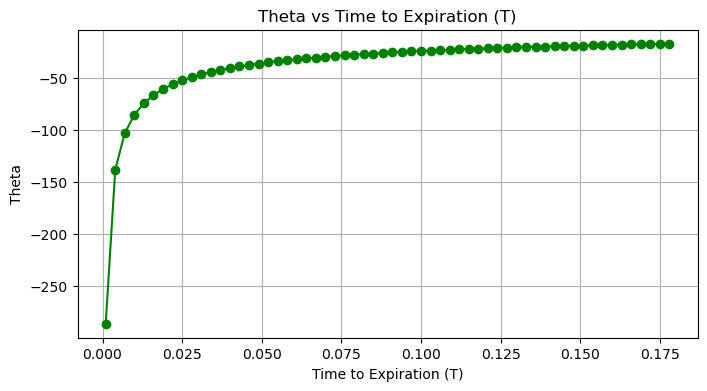

In [11]:
# Plotting Theta
plt.figure(figsize=(8, 4))
plt.plot(T_values_2, thetas, label='Theta', marker='o', color='green')
plt.title('Theta vs Time to Expiration (T)')
plt.xlabel('Time to Expiration (T)')
plt.ylabel('Theta')
plt.grid(True)
plt.show()

#### 2(i) Vega of an American Put Option as a function of underlying

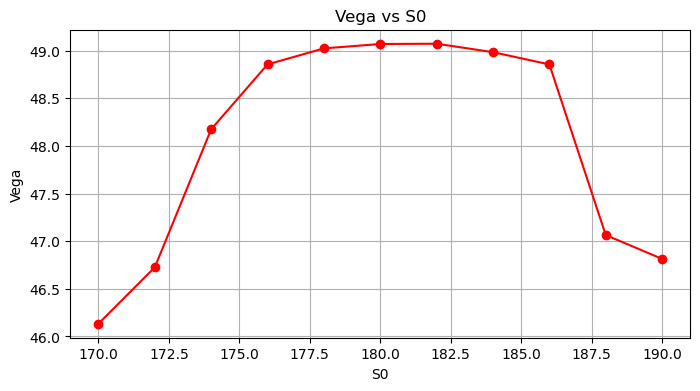

In [12]:
# Plotting Vega
plt.figure(figsize=(8, 4))
plt.plot(S0_values, vegas, label='Vega', marker='o', color='red')
plt.title('Vega vs S0')
plt.xlabel('S0')
plt.ylabel('Vega')
plt.grid(True)
plt.show()

### 3. Convergence Rates of Trinomial Methods

In [13]:
# defining parameters and number of steps
S0 = 180
K = 180
T = 0.5
r = 0.055
sigma = 0.25
steps = [20, 40, 70, 80, 100, 200, 500]

#### 3(a) Trinomial Methods for Stock Prices

In [14]:
def calc_american_put_price_trinomial_1(S0, K, T, r, sigma, n):
    dt = T / n
    u = np.exp(sigma * np.sqrt(3 * dt))
    d = 1 / u
    m = 1  # no price movement
    # defining probabilities of moves
    p_u = ((r * dt * (1 - d) + (r * dt)**2 + sigma**2 * dt) / ((u - m) * (u - d)))

    p_d = ((r * dt * (1 - u) + (r * dt)**2 + sigma**2 * dt) / ((u - d) * (m - d)))
    p_m = 1 - p_u - p_d

    # initializing stock prices and option values
    stock_prices = np.zeros((n+1, 2*n+1))
    option_values = np.zeros((n+1, 2*n+1))

    # setting stock prices at maturity
    for j in range(2*n+1):
        stock_prices[n, j] = S0 * (u ** max(0, n - j)) * (d ** -min(0, n - j))

    # setting option values at maturity
    option_values[n, :] = np.maximum(K - stock_prices[n, :], 0)

    # looping through backward induction
    for i in range(n-1, -1, -1):
        for j in range(2*i+1):
            # indices for up, middle, down nodes in the next time step
            idx_up = j
            idx_middle = j + 1
            idx_down = j + 2

            # calculating option value at node (i, j)
            option_values[i, j] = (
                p_u * option_values[i+1, idx_up] +
                p_m * option_values[i+1, idx_middle] +
                p_d * option_values[i+1, idx_down]
            ) * np.exp(-r * dt)

            exercise_value = K - S0 * (u ** max(0, i - j)) * (d ** -min(0, i - j))
            option_values[i, j] = max(option_values[i, j], exercise_value)
    return option_values[0, 0]  # getting back to the starting point to get the option value

prices_1 = [calc_american_put_price_trinomial_1(S0, K, T, r, sigma, n) for n in steps]

#### 3(b) Trinomial Methods for Log-Stock Prices

In [15]:
# defining parameters and number of steps
S0 = 180
K = 180
T = 0.5
r = 0.055
sigma = 0.25
steps = [20, 40, 70, 80, 100, 200, 500]

In [16]:
def calc_american_put_price_trinomial_1(S0, K, T, r, sigma, n):
    dt = T / n
    dx = sigma * np.sqrt(3 * dt)  # ΔXu = ΔXd = σ√3Δ
    u = np.exp(dx)
    d = np.exp(-dx)

    # defining probabilities of moves using the given formulas
    p_u = 0.5 * (((sigma**2) * dt + (r - sigma**2 / 2)**2 * dt**2) / dx**2 + (r - sigma**2 / 2) * dt / dx)
    p_d = 0.5 * (((sigma**2) * dt + (r - sigma**2 / 2)**2 * dt**2) / dx**2 - (r - sigma**2 / 2) * dt / dx)
    p_m = 1 - p_u - p_d

    # initializing stock prices and option values
    stock_prices = np.zeros((n + 1, 2 * n + 1))
    option_values = np.zeros((n + 1, 2 * n + 1))

    # setting stock prices at maturity
    for j in range(2 * n + 1):
        stock_prices[n, j] = np.log(S0 * (u ** max(0, n - j)) * (d ** -min(0, n - j)))

    # setting option values at maturity
    option_values[n, :] = np.maximum(K - np.exp(stock_prices[n, :]), 0)

    # looping through backward induction
    for i in range(n - 1, -1, -1):
        for j in range(2 * i + 1):
            # indices for up, middle, down nodes in the next time step
            idx_up = j
            idx_middle = j + 1
            idx_down = j + 2

            # calculating option value at node (i, j)
            option_values[i, j] = (
                p_u * option_values[i + 1, idx_up] +
                p_m * option_values[i + 1, idx_middle] +
                p_d * option_values[i + 1, idx_down]
            ) * np.exp(-r * dt)

            exercise_value = K - np.exp((np.log(S0 * (u ** max(0, i - j)) * (d ** -min(0, i - j)))))
            option_values[i, j] = max(option_values[i, j], exercise_value)
    return option_values[0, 0]  # Middle of the array corresponds to the original price

prices = [calc_american_put_price_trinomial_1(S0, K, T, r, sigma, n) for n in steps]

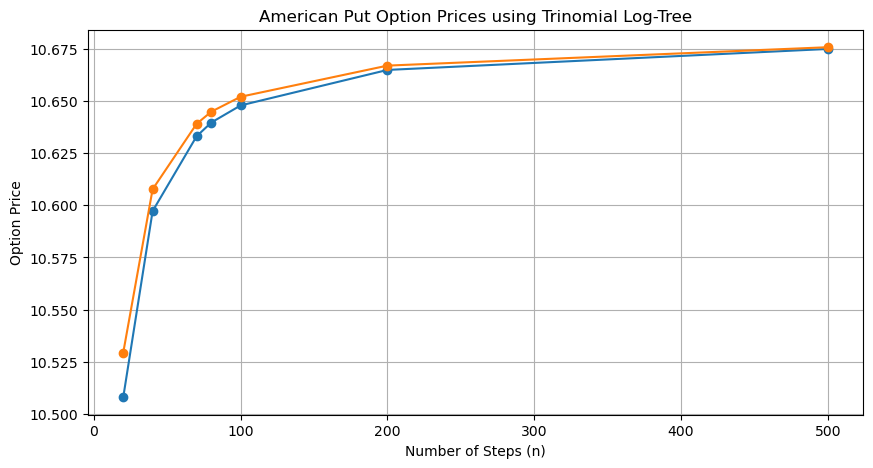

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(steps, prices_1, marker='o')
plt.plot(steps, prices, marker='o', linestyle='-')
plt.title('American Put Option Prices using Trinomial Log-Tree')
plt.xlabel('Number of Steps (n)')
plt.ylabel('Option Price')
plt.grid(True)
plt.show()

## Lecture 5: Least Square Monte Carlo Method

### 4. Pricing Options using different Polynomials

In [18]:
S0 = 180
K = 180
sigma = 0.25
r = 0.055
N = 100000
T = [0.5, 1.5]
delta = 1 / np.sqrt(N)

np.random.seed(75)

def laguerre(x, k):
    if k > 4:
        raise ValueError("k must be between 0 to 4")
    coefficients = [
        [1],
        [1, -1],
        [1, -2, 0.5],
        [1, -3, 1.5, -1/6],
        [1, -4, 3, -2/3, 1/24]
    ]
    result = np.exp(-x/2) * np.polyval(list(reversed(coefficients[k])), x)
    return result

def hermite(x, k):
    if k == 0:
        return np.ones_like(x)
    elif k == 1:
        return 2 * x
    elif k == 2:
        return 4 * x**2 - 2
    elif k == 3:
        return 8 * x**3 - 12 * x
    elif k == 4:
        return 16 * x**4 - 56 * x**2 + 16
    else:
        raise ValueError("Hermite polynomial for k > 4 is required")

def monomial(x, k):
    return x**k

In [19]:
np.random.seed(75)

def generate_asset_paths(initial_price, volatility, interest_rate, maturity, num_paths, time_step):
    num_time_steps = int(maturity / time_step)  # Number of time intervals based on the total time and time step size
    asset_paths = np.zeros((num_paths, num_time_steps + 1))
    asset_paths[:, 0] = initial_price  # Setting the initial asset price for all paths

    for time_index in range(1, num_time_steps + 1):
        random_shocks = np.random.normal(0, 1, num_paths // 2)
        random_shocks = np.concatenate((random_shocks, -random_shocks))  # Using antithetic variates to reduce variance
        asset_paths[:, time_index] = asset_paths[:, time_index - 1] * np.exp(
            (interest_rate - 0.5 * volatility**2) * time_step + volatility * np.sqrt(time_step) * random_shocks)

    return asset_paths

def calculate_american_put_option(asset_paths, strike_price, interest_rate, time_step, max_degree, poly_type):
    num_steps = asset_paths.shape[1] - 1
    # Calculate the payoffs at maturity (European payoff)
    final_payoffs = np.maximum(strike_price - asset_paths[:, num_steps], 0)

    # Select the appropriate polynomial function based on the specified type
    polynomial_functions = {
        'laguerre': laguerre,
        'hermite': hermite,
        'monomial': monomial
    }
    if poly_type not in polynomial_functions:
        raise ValueError("Unknown function type. Use 'laguerre', 'hermite', or 'monomial'.")
    poly_func = polynomial_functions[poly_type]

    # Iterate backwards through the asset paths to calculate option value at each step
    for t in range(num_steps - 1, 0, -1):
        in_the_money_mask = asset_paths[:, t] < strike_price
        stock_prices = asset_paths[in_the_money_mask, t]
        continuing_values = final_payoffs[in_the_money_mask]

        # Only proceed if there are in-the-money paths
        if len(stock_prices) == 0:
            continue

        # Build polynomial matrix
        polynomial_matrix = np.vstack([poly_func(stock_prices / strike_price, i) for i in range(max_degree)]).T
        # Least squares regression to find continuation values
        regression_coeffs = np.linalg.lstsq(polynomial_matrix, continuing_values * np.exp(-interest_rate * time_step), rcond=None)[0]
        continuation_values = polynomial_matrix.dot(regression_coeffs)

        # Immediate exercise values
        immediate_exercise_values = np.maximum(strike_price - stock_prices, 0)

        # Determine where to exercise options immediately
        exercise_now = immediate_exercise_values > continuation_values

        # Update payoffs based on the optimal exercise policy
        final_payoffs[in_the_money_mask] = np.where(exercise_now, immediate_exercise_values, continuing_values * np.exp(-interest_rate * time_step))

    # Calculate the expected payoff of the option discounted to present value
    return np.mean(final_payoffs * np.exp(-interest_rate * time_step))

#### 4(a) Laguerre Polynomials

In [20]:
df_laguerre_results = pd.DataFrame(columns=['k', '0.5 years', '1.5 years'])

for k in range(2, 6):
    row = {'k': k}
    for maturity in T:
        paths = generate_asset_paths(S0, sigma, r, maturity, N, delta)
        price = calculate_american_put_option(paths, K, r, delta, k, poly_type='laguerre')
        row[f'{maturity} years'] = price
    df_laguerre_results = pd.concat([df_laguerre_results, pd.DataFrame([row])], ignore_index=True)

df_laguerre_results

,k,0.5 years,1.5 years
0,2,10.649106,16.409938
1,3,10.679578,16.486000
2,4,10.706812,16.515363
3,5,10.721039,16.492291


#### 4(b) Hermite Polynomials

In [21]:
df_hermite_results = pd.DataFrame(columns=['k', '0.5 years', '1.5 years'])

for k in range(2, 6):
    row = {'k': k}
    for maturity in T:
        paths = generate_asset_paths(S0, sigma, r, maturity, N, delta)
        price = calculate_american_put_option(paths, K, r, delta, k, poly_type='hermite')
        row[f'{maturity} years'] = price
    df_hermite_results = pd.concat([df_hermite_results, pd.DataFrame([row])], ignore_index=True)

df_hermite_results

,k,0.5 years,1.5 years
0,2,10.566825,16.181360
1,3,10.704766,16.477891
2,4,10.687906,16.522270
3,5,10.720103,16.508051


#### 4(c) Simple Monomials

In [22]:
df_monomial_results = pd.DataFrame(columns=['k', '0.5 years', '1.5 years'])

for k in range(2, 6):
    row = {'k': k}
    for maturity in T:
        paths = generate_asset_paths(S0, sigma, r, maturity, N, delta)
        price = calculate_american_put_option(paths, K, r, delta, k, poly_type='monomial')
        row[f'{maturity} years'] = price
    df_monomial_results = pd.concat([df_monomial_results, pd.DataFrame([row])], ignore_index=True)

df_monomial_results

,k,0.5 years,1.5 years
0,2,10.621037,16.238764
1,3,10.684070,16.453710
2,4,10.735831,16.567635
3,5,10.701882,16.577975


## Lecture 6: Numerical PDE Method

### 5. Finite Differencing Methods for Log Prices

In [25]:
# Parameters
K = 180
T = 0.5
r = 0.055
sigma = 0.25
dt = 0.002
dx = sigma * np.sqrt(1 * dt)
dx3 = sigma * np.sqrt(3 * dt)
dx4 = sigma * np.sqrt(4 * dt)
Smin = np.log(170) - 3 * sigma * np.sqrt(T)
Smax = np.log(190) + 3 * sigma * np.sqrt(T)

#### 5(a) Explicit Finite-Difference method

In [26]:
def explicit_finite_difference(K, T, r, sigma, dx, dt, Smin, Smax, S0):
    # Calculate N, M
    N = int((Smax - Smin) / dx)
    M = int(T / dt)

    # Create grid for stock prices and option values
    x_values = np.linspace(Smin, Smax, N + 1)
    V = np.zeros((M + 1, N + 1))

    # Set up initial condition (at maturity)
    V[M, :] = np.maximum(K - np.exp(x_values), 0)

    # Probabilities
    pu = dt * (sigma**2 / (2 * dx**2) + (r - sigma**2 / 2) / (2 * dx))
    pm = 1 - dt * (sigma**2 / (dx**2)) - r * dt
    pd = dt * (sigma**2 / (2 * dx**2) - (r - sigma**2 / 2) / (2 * dx))

    # Solve the PDE
    for i in range(M - 1, -1, -1):
        V[i, N] = V[i + 1, N-1]  # Applying condition for large S
        V[i, 0] = V[i + 1, 1] + (np.exp(x_values[0]) - np.exp(x_values[1]))  # Applying condition for small S

        for j in range(1, N):
            V[i, j] = pu * V[i + 1, j + 1] + pm * V[i + 1, j] + pd * V[i + 1, j - 1]
            # Enforce American condition
            V[i, j] = max(V[i, j], K - np.exp(x_values[j]))

    # Interpolate the result at S0
    actual_prices = np.exp(x_values)
    option_price = np.interp(S0, actual_prices, V[0, :])

    return option_price

# Stock prices and option prices
stock_prices = np.arange(170, 191, 1)
option_prices = [explicit_finite_difference(K, T, r, sigma, dx, dt, Smin, Smax, S0) for S0 in stock_prices]
option_prices_3 = [explicit_finite_difference(K, T, r, sigma, dx3, dt, Smin, Smax, S0) for S0 in stock_prices]
option_prices_4 = [explicit_finite_difference(K, T, r, sigma, dx4, dt, Smin, Smax, S0) for S0 in stock_prices]
df_results = pd.DataFrame({'Stock Price': stock_prices, 'Put Option Value': option_prices_3})
formatted_results = df_results.style.format({'Put Option Value': "${:.2f}"})
formatted_results

,Stock Price,Put Option Value
0,170,$15.77
1,171,$15.21
2,172,$14.66
3,173,$14.11
4,174,$13.60
5,175,$13.10
6,176,$12.59
7,177,$12.12
8,178,$11.67
9,179,$11.21


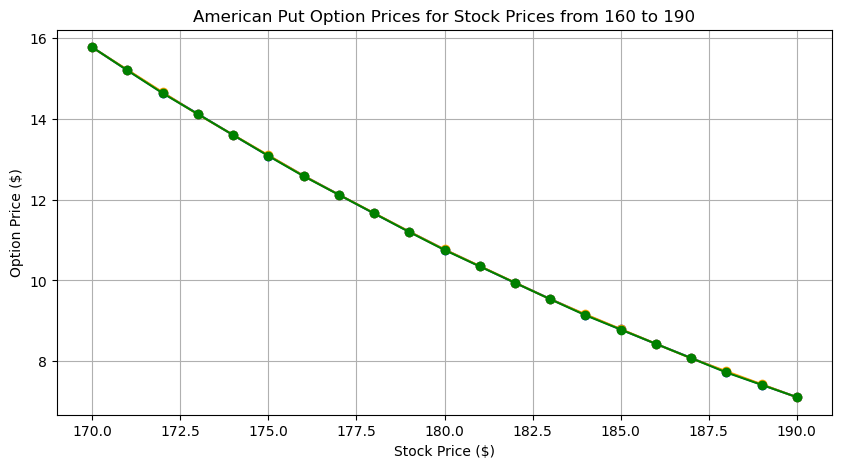

In [27]:
# plotting
plt.figure(figsize=(10, 5))
plt.plot(stock_prices, option_prices, '-o', color='blue')
plt.plot(stock_prices, option_prices_3, '-o', color='orange')
plt.plot(stock_prices, option_prices_4, '-o', color='green')
plt.title('American Put Option Prices for Stock Prices from 160 to 190')
plt.xlabel('Stock Price ($)')
plt.ylabel('Option Price ($)')
plt.grid(True)
plt.show()

#### 5(b) Implicit Finite-Difference method

In [28]:
# Parameters
K = 180
T = 0.5
r = 0.055
sigma = 0.25
dt = 0.002
dx = sigma * np.sqrt(1 * dt)
dx3 = sigma * np.sqrt(3 * dt)
dx4 = sigma * np.sqrt(4 * dt)

Smax = np.log(190) + 3 * sigma * np.sqrt(T)
Smin = np.log(170) - 3 * sigma * np.sqrt(T)

In [29]:
def implicit_finite_difference(K, T, r, sigma, dx, dt, Smin, Smax, S0):
    N = int((Smax - Smin) / dx)
    M = int(T / dt)

    # Grid for stock prices and option values
    x_values = np.linspace(Smin, Smax, N + 1)
    V = np.zeros((M + 1, N + 1))

    # Initial condition at maturity
    V[M, :] = np.maximum(K - np.exp(x_values), 0)

    # Probabilities
    pu = -0.5 * dt * (sigma**2 / dx**2 + (r - sigma**2 / 2) / dx)
    pm = 1 + dt * (sigma**2 / dx**2 + r)
    pd = -0.5 * dt * (sigma**2 / dx**2 - (r - sigma**2 / 2) / dx)

    # Tridiagonal matrix components
    A = np.diag([pm] * (N + 1)) + np.diag([pu] * N, k=1) + np.diag([pd] * N, k=-1)
    A[0, 0], A[0, 1] = 1, -1
    A[-1, -1], A[-1, -2] = 1, -1

    for i in range(M - 1, -1, -1):
        b = V[i + 1, :]
        b[-1] = 0  # Adjusted for large S
        b[0] = (np.exp(x_values[0]) - np.exp(x_values[1]))  # Adjusted for small S

        V[i, :] = np.linalg.solve(A, b)  # Solve the system

        # Enforce the American option condition
        V[i, :] = np.maximum(V[i, :], K - np.exp(x_values))

    # Interpolate the result at S0
    actual_prices = np.exp(x_values)
    option_price = np.interp(S0, actual_prices, V[0, :])

    return option_price

In [30]:
# Stock prices and option prices
stock_prices = np.arange(170, 191, 1)
option_prices = [implicit_finite_difference(K, T, r, sigma, dx, dt, Smin, Smax, S0) for S0 in stock_prices]
df_results = pd.DataFrame({'Stock Price': stock_prices, 'Put Option Value': option_prices})
formatted_results = df_results.style.format({'Put Option Value': "${:.2f}"})
# formatted_results

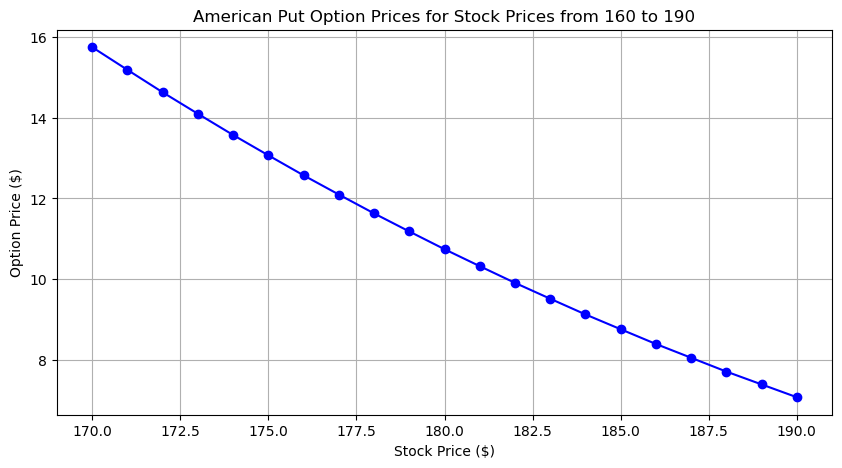

In [31]:
# plotting
plt.figure(figsize=(10, 5))
plt.plot(stock_prices, option_prices, '-o', color='blue')
plt.title('American Put Option Prices for Stock Prices from 160 to 190')
plt.xlabel('Stock Price ($)')
plt.ylabel('Option Price ($)')
plt.grid(True)
plt.show()

#### 5(c) Crank-Nicolson Finite-Difference method

In [32]:
# Parameters
K = 180
T = 0.5
r = 0.055
sigma = 0.25
dt = 0.002
dx = sigma * np.sqrt(1 * dt)
dx3 = sigma * np.sqrt(3 * dt)
dx4 = sigma * np.sqrt(4 * dt)

Smax = np.log(190) + 3 * sigma * np.sqrt(T)
Smin = np.log(170) - 3 * sigma * np.sqrt(T)

In [33]:
def crank_nicolson_finite_difference(K, T, r, sigma, dx, dt, Smin, Smax, S0):
    N = int((Smax - Smin) / dx)
    M = int(T / dt)

    # Grid for stock prices and option values
    x_values = np.linspace(Smin, Smax, N + 1)
    V = np.zeros((M + 1, N + 1))

    # Initial condition at maturity
    V[M, :] = np.maximum(K - np.exp(x_values), 0)

    # Coefficients for the Crank-Nicolson method
    pu = -0.25 * dt * (sigma**2 / dx**2 + (r - sigma**2 / 2) / dx)
    pm = 1 + 0.5 * dt * (sigma**2 / dx**2 + r)
    pd = -0.25 * dt * (sigma**2 / dx**2 - (r - sigma**2 / 2) / dx)

    # Matrix setup for A and B
    A = np.diag([pm] * (N + 1)) + np.diag([pu] * N, k=1) + np.diag([pd] * N, k=-1)
    B = np.diag([2-pm] * (N + 1)) - np.diag([pu] * N, k=1) - np.diag([pd] * N, k=-1)
    # print(B)
    A[0, 0], A[0, 1] = 1, -1
    A[-1, -1], A[-1, -2] = 1, -1
    # print(A)

    for i in range(M - 1, -1, -1):
        b = B @ V[i + 1, :]
        b[0] = (np.exp(x_values[0]) - np.exp(x_values[1]))  # small S
        b[-1] = 0  # large S

        V[i, :] = scipy.linalg.solve(A, b)  # Solve the system

        # American option condition
        V[i, :] = np.maximum(V[i, :], K - np.exp(x_values))

    # Interpolate the result at S0
    actual_prices = np.exp(x_values)
    option_price = np.interp(S0, actual_prices, V[0, :])

    return option_price

In [34]:
# Stock prices and option prices
stock_prices = np.arange(170, 191, 1)
option_prices = [crank_nicolson_finite_difference(K, T, r, sigma, dx, dt, Smin, Smax, S0) for S0 in stock_prices]
df_results = pd.DataFrame({'Stock Price': stock_prices, 'Put Option Value': option_prices})
formatted_results = df_results.style.format({'Put Option Value': "${:.2f}"})
# formatted_results

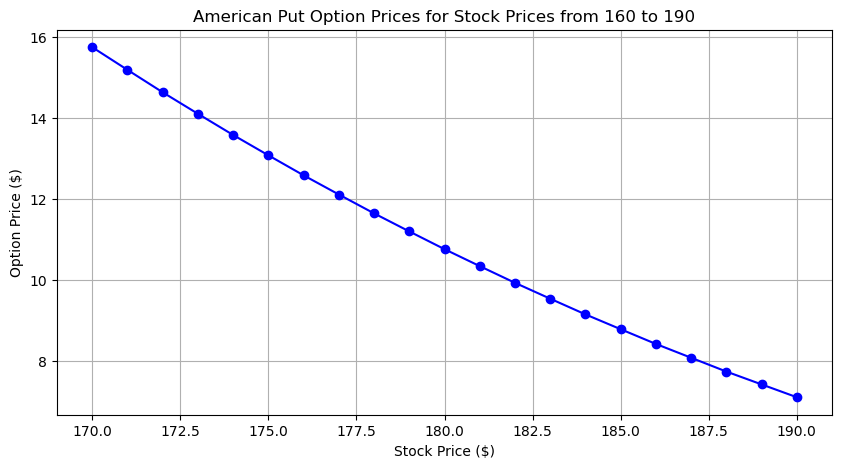

In [35]:
# plotting
plt.figure(figsize=(10, 5))
plt.plot(stock_prices, option_prices, '-o', color='blue')
plt.title('American Put Option Prices for Stock Prices from 160 to 190')
plt.xlabel('Stock Price ($)')
plt.ylabel('Option Price ($)')
plt.grid(True)
plt.show()

### 6. Finite Differencing Methods for Stock Prices

In [36]:
# Define parameters
K = 180
sigma = 0.25
r = 0.055
T = 0.5
dt = 0.002
stock_prices = np.linspace(170, 190, 21)

In [37]:
def generalized_finite_diff(S0, K, sigma, r, T, dS, dt, alpha):
    S_max = S0 * 2
    S_min = 0
    length_prices = int((S_max - S_min) / dS)
    S = np.linspace(S_max, S_min, length_prices + 1)
    N = len(S)

    j = np.arange(N-1, 0, -1)
    a1 = 0.5 * (sigma**2 * j**2 - r * j) * (1-alpha)
    a2 = -1/dt - (sigma**2 * j**2 + r) * (1-alpha)
    a3 = 0.5 * (sigma**2 * j**2 + r * j) * (1-alpha)
    b1 = 0.5 * (sigma**2 * j**2 - r * j) * alpha
    b2 = 1/dt - (sigma**2 * j**2 + r) * alpha
    b3 = 0.5 * (sigma**2 * j**2 + r * j) * alpha

    A = np.diag(a2) + np.diag(a1[:-1], 1) + np.diag(a3[1:], -1)
    F = np.maximum(K - S[1:], 0)
    B = np.zeros(N-1)
    B[1:-1] = -b1[1:-1] * F[2:] - b2[1:-1] * F[1:-1] - b3[1:-1] * F[:-2]
    B[0] = 0
    B[-1] = S[-1] - S[-2]

    for _ in range(int(T / dt)):
        F = np.linalg.solve(A, B)
        F = np.maximum(F, K - S[1:])  # Enforce American condition
        B[1:-1] = -b1[1:-1] * F[2:] - b2[1:-1] * F[1:-1] - b3[1:-1] * F[:-2]
        B[0] = 0
        B[-1] = S[-1] - S[-2]

    return F

#### 6(a) Explicit Finite-Difference method

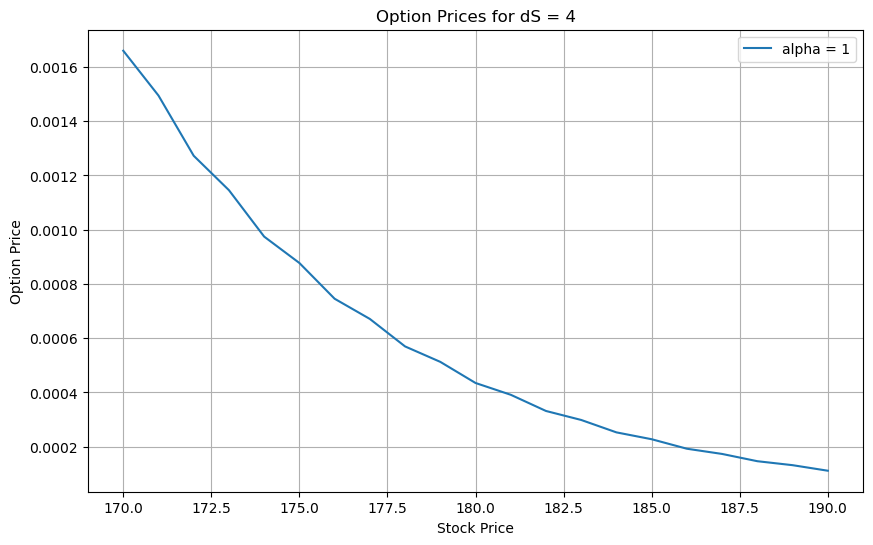

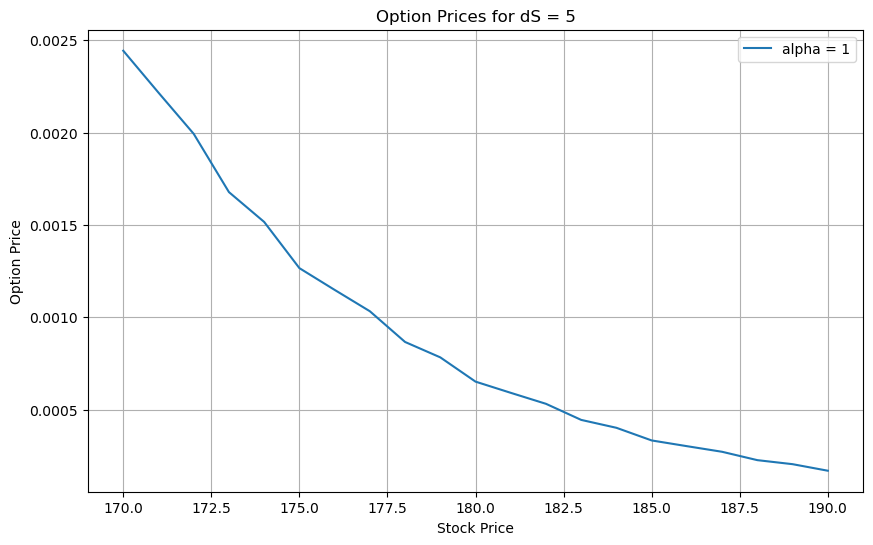

In [38]:
# Plotting
ds_values = [4, 5]
alpha_values = [1]

for dS in ds_values:
    plt.figure(figsize=(10, 6))
    for alpha in alpha_values:
        option_prices  = [generalized_finite_diff(S0, K, sigma, r, T, dS, dt, alpha)[2] for S0 in stock_prices]
        plt.plot(stock_prices, option_prices, label=f'alpha = {alpha}')
    plt.title(f'Option Prices for dS = {dS}')
    plt.xlabel('Stock Price')
    plt.ylabel('Option Price')
    plt.legend()
    plt.grid(True)
    plt.show()

#### 6(b) and 6(c) Implicit and Crank-Nicolson Finite-Difference method

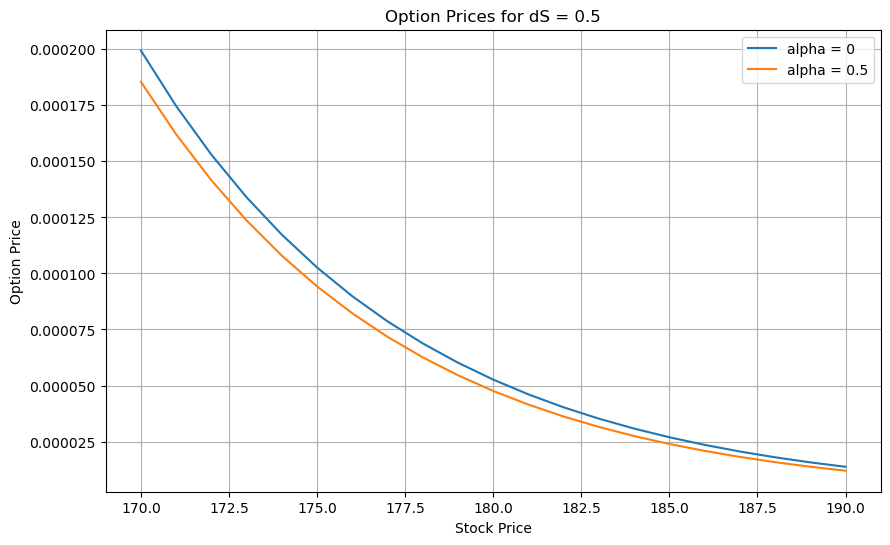

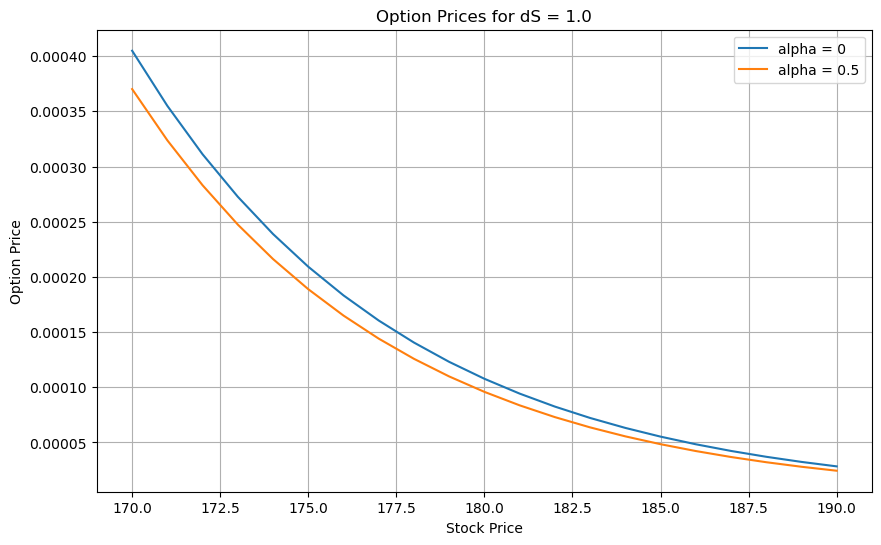

In [39]:
# Plotting
ds_values = [0.5, 1.0]
alpha_values = [0, 0.5]

for dS in ds_values:
    plt.figure(figsize=(10, 6))
    for alpha in alpha_values:
        option_prices  = [generalized_finite_diff(S0, K, sigma, r, T, dS, dt, alpha)[2] for S0 in stock_prices]
        plt.plot(stock_prices, option_prices, label=f'alpha = {alpha}')
    plt.title(f'Option Prices for dS = {dS}')
    plt.xlabel('Stock Price')
    plt.ylabel('Option Price')
    plt.legend()
    plt.grid(True)
    plt.show()